In [1]:
import guardrails as gd
import openai
from rich import print as rprint
import tiktoken
import dotenv
import os
import pandas as pd

from app.database import Database, db_config

from app.guardrails_specs.specs import rail_str

dotenv.load_dotenv()
OPEN_API_KEY = os.getenv("OPENAI_API_KEY")
openai.api_key = OPEN_API_KEY


## Checking if basic guardrails calls work

In [ ]:
# Create a Guard class
guard = gd.Guard.from_rail_string(rail_str)

test_transaction = '''
Date
	
Transaction Description
	
Debit
	
Credit
	Balance
Jul 22, 2023	AMZ*Sleepsheep Direct		$141.75	$4,838.90
Jul 22, 2023	FIVE GUYS BURGERS & FR	$71.12		$4,980.65
Jul 22, 2023	ABC*ANYTIME FITNESS	$28.34		$4,909.53
Jul 21, 2023	RING MULTICAM MTH PLAN	$15.75		$4,881.19
Jul 19, 2023	DOORDASH*LUNA MEXICAN	$130.82		$4,865.44
Jul 18, 2023	PAYMENT - THANK YOU		$300.00	$4,734.62
Jul 16, 2023	SOLARA RESORT AND SPA	$63.00		$5,034.62
Jul 16, 2023	EDMONTO*3CINTEGRA PARKI	$87.00		$4,971.62
Jul 16, 2023	AMZN Mktp CA*TU5VJ3VX3	$16.73		$4,884.62
Jul 16, 2023	Amazon.ca*J29G10HJ3	$123.90		$4,867.89
Jul 16, 2023	ENTERPRISE CANADA C5E2	$428.22		$4,743.99
'''

# Wrap openai API call

raw_llm_output, guardrail_output = guard(
    openai.ChatCompletion.create,
    prompt_params={"transaction_string": test_transaction},
    
    model="gpt-3.5-turbo",
    max_tokens=2000,
    temperature=0.0,
    num_reasks=0,
)

rprint(guardrail_output)


## Testing with the AI Assistant

### Bare bones test

In [ ]:
database = Database(**db_config)

test_user_id = 3

def convert_transactions_to_dataframe(user_id: int):
    transactions = database.get_all_transactions_by_user_id(user_id=user_id)
    df = pd.DataFrame(
        [
            {
                "transaction_id": transaction.transaction_id,
                "transaction_date": transaction.transaction_date,
                "transaction_description": transaction.transaction_description,
                "credit": transaction.credit,
                "amount": transaction.debit,
                "account_id": transaction.account_id,
                "category_id": transaction.category_id,
                "user_id": transaction.user_id,
                "category": category.category_name,
            }
            for transaction, category in transactions
        ]
    )

    return df

# converting transactions to a dataframe
df = convert_transactions_to_dataframe(test_user_id)
df.head()

In [ ]:
# creating the specs for the guardrails

rail_fin = """
<rail version="0.1">

<output>
    <object name="financial_answer">
        <string name="explanation"/>
        <pythoncode
            name="python_code"
            format="bug-free-python"
            on-fail-bug-free-python="reask"
        />
    </object>
</output>

<instructions>
You are a smart financial assitant that knows how to code in Python. You can provide explanations for your rationale and also provide the code to back it up.

@json_suffix_prompt_examples
</instructions>


<prompt>
You have at your disposal a pandas dataframe called `df` that contains the following columns:

- transaction_date: The date of the transaction
- transaction_description: The description of the transaction
- amount: The amount of money debited from the account
- category: The category of the transaction. 


Given the financial question below, provide a list of explanations and possible queries to back you up.

Financial Question:
{{financial_question}}

@complete_json_suffix</prompt>

</rail>
"""

rail_fin2 = """
<rail version="0.1">

<output>
    <object name="financial_answer">
        <string name="explanation_string"/>
        <pythoncode
            name="python_code"
            format="bug-free-python"
        />
    </object>
</output>

<instructions>
You are a smart financial assitant that knows how to code in Python. You can provide explanations for your rationale and also provide the code to back it up.

@json_suffix_prompt_examples
</instructions>


<prompt>
You have at your disposal a pandas dataframe called `df` that contains the following columns:

- transaction_date: The date of the transaction
- transaction_description: The description of the transaction
- amount: The amount of money debited from the account
- category: The category of the transaction. 

Generate a list of explanations and the string to be completed in the financial question below. specify what are the variables you need to complete the string.

Financial Question:
{{financial_question}}

@complete_json_suffix</prompt>

</rail>
"""

In [ ]:
guard = gd.Guard.from_rail_string(rail_fin2)

financial_question = """
How much did I spend on groceries in the last 3 months?
"""

raw_llm_response, validated_response = guard(
    openai.ChatCompletion.create,
    prompt_params={"financial_question": financial_question},
    model="gpt-3.5-turbo",
    max_tokens=3000,
    temperature=0,
)


In [ ]:
rprint(validated_response)

In [ ]:
rprint(raw_llm_response)

In [ ]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
groceries_df = df[(df['category'] == 'groceries') & (df['transaction_date'] >= pd.Timestamp.now() - pd.DateOffset(months=3))]
total_spent = groceries_df['amount'].sum()
total_spent

### Testing pandas ai

#### Random test

In [2]:
from pandasai import PandasAI


database = Database(**db_config)

test_user_id = 3

def convert_transactions_to_dataframe(user_id: int):
    transactions = database.get_all_transactions_by_user_id(user_id=user_id)
    df = pd.DataFrame(
        [
            {
                "transaction_id": transaction.transaction_id,
                "transaction_date": transaction.transaction_date,
                "transaction_description": transaction.transaction_description,
                "credit": transaction.credit,
                "amount": transaction.debit,
                "account_id": transaction.account_id,
                "category_id": transaction.category_id,
                "user_id": transaction.user_id,
                "category": category.category_name,
            }
            for transaction, category in transactions
        ]
    )

    return df

# converting transactions to a dataframe
df = convert_transactions_to_dataframe(test_user_id)
df.head()

2023-08-09 19:59:43,440 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-08-09 19:59:43,441 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-08-09 19:59:43,445 INFO sqlalchemy.engine.Engine select current_schema()
2023-08-09 19:59:43,445 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-08-09 19:59:43,448 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-08-09 19:59:43,448 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-08-09 19:59:43,450 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-08-09 19:59:43,452 INFO sqlalchemy.engine.Engine SELECT llm_finances.transactions.transaction_id AS llm_finances_transactions_transaction_id, llm_finances.transactions.transaction_date AS llm_finances_transactions_transaction_date, llm_finances.transactions.transaction_description AS llm_finances_transactions_transaction_description, llm_finances.transactions.credit AS llm_finances_transactions_credit, llm_finances.transactions.debit AS llm_finances_transactions_debit, ll

/Users/fernandomeira/projects/LLM-budget-assistant/app/database.py:219: SAWarning: relationship 'User.user_accounts' will copy column users.user_id to column accounts.user_id, which conflicts with relationship(s): 'Account.users' (copies users.user_id to accounts.user_id), 'User.accounts' (copies users.user_id to accounts.user_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="accounts,users"' to the 'User.user_accounts' relationship. (Background on this warning at: https://sqlalche.me/e/20/qzyx) (This warning originated from the `configure_mappers()` process, which was invoked automatically in response to a user-initiated operat

,transaction_id,transaction_date,transaction_description,credit,amount,account_id,category_id,user_id,category
0,237,2023-01-01,"FIVE GUYS BURGERS & FR, 780-436-9885",0.0,46.66,4,17,3,Takeout
1,234,2023-01-02,"SAVE ON FOODS #6622, EDMONTON",0.0,30.31,4,24,3,Grocery
2,236,2023-01-02,"DOLLARAMA #1101, EDMONTON",0.0,46.28,4,30,3,Home Goods
3,235,2023-01-02,"MCDONALD'S #40413, EDMONTON",0.0,8.38,4,17,3,Takeout
4,231,2023-01-06,"PC EXPRESS 1549, EDMONTON",0.0,97.90,4,24,3,Grocery


<string>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


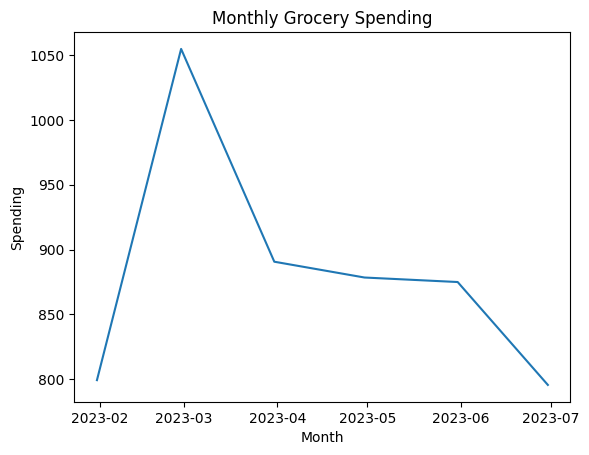

None

In [8]:
from pandasai import PandasAI

# Instantiate a LLM
from pandasai.llm.openai import OpenAI
llm = OpenAI(api_token=OPEN_API_KEY)

pandas_ai = PandasAI(llm)
rprint(pandas_ai(df, prompt='plot for me my grocery spending monthly'))

In [ ]:
rprint(pandas_ai(df, prompt='Give me some tips on how to save 10% of all my spending monthly'))

month
1    204.276
2    205.736
3    235.519
4    224.565
5    278.786
6    238.527
Name: amount, dtype: float64

#### Chaining it with Langchain

In [10]:
from pandasai import PandasAI


database = Database(**db_config)

test_user_id = 3

def convert_transactions_to_dataframe(user_id: int):
    transactions = database.get_all_transactions_by_user_id(user_id=user_id)
    df = pd.DataFrame(
        [
            {
                "transaction_id": transaction.transaction_id,
                "transaction_date": transaction.transaction_date,
                "transaction_description": transaction.transaction_description,
                "credit": transaction.credit,
                "amount": transaction.debit,
                "account_id": transaction.account_id,
                "category_id": transaction.category_id,
                "user_id": transaction.user_id,
                "category": category.category_name,
            }
            for transaction, category in transactions
        ]
    )

    return df

# converting transactions to a dataframe
df = convert_transactions_to_dataframe(test_user_id)


from pandasai import PandasAI

# Instantiate a LLM
from pandasai.llm.openai import OpenAI
llm = OpenAI(api_token=OPEN_API_KEY)

pandas_ai = PandasAI(llm)
# rprint(pandas_ai(df, prompt='plot for me my grocery spending monthly'))

2023-08-09 20:32:25,561 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-08-09 20:32:25,562 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-08-09 20:32:25,566 INFO sqlalchemy.engine.Engine select current_schema()
2023-08-09 20:32:25,567 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-08-09 20:32:25,569 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-08-09 20:32:25,570 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-08-09 20:32:25,571 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-08-09 20:32:25,572 INFO sqlalchemy.engine.Engine SELECT llm_finances.transactions.transaction_id AS llm_finances_transactions_transaction_id, llm_finances.transactions.transaction_date AS llm_finances_transactions_transaction_date, llm_finances.transactions.transaction_description AS llm_finances_transactions_transaction_description, llm_finances.transactions.credit AS llm_finances_transactions_credit, llm_finances.transactions.debit AS llm_finances_transactions_debit, ll

#### Using the pandas ai base prompt

In [34]:
from pandasai.helpers.anonymizer import anonymize_dataframe_head

from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)

# generating reference data for the dataframe

df_ref = {
    'df_head': anonymize_dataframe_head(df),
    'num_rows': df.shape[0],
    'num_columns': df.shape[1],
}


# Taking the idea from pandas-ai, we can pass the dataframe data to the first prompt and ask it to generate a generic pandas call

initial_prompt = """
    You are provided with a pandas dataframe (df) with {num_rows} rows and {num_columns} columns.
    This is the metadata of the dataframe:
    {df_head}.

    You will be given a question that needs to be answered with the data above. Generate a JSON object with the following attributes:

    - next step: can this be solved with a single pandas call? (yes/no)
    - pandas call: if yes, what is the pandas call that solves this question?
    - pandas call explanation: if yes, explain how this pandas call solves the question

    question: {question}
"""


human_message_prompt = HumanMessagePromptTemplate(
        prompt=PromptTemplate(
            template=initial_prompt,
            input_variables=["num_rows", "num_columns", "df_head", "question"],
        )
    )
chat_prompt_template = ChatPromptTemplate.from_messages([human_message_prompt])
chat = ChatOpenAI(temperature=0)
chain = LLMChain(llm=chat, prompt=chat_prompt_template)
print(chain.run(**df_ref, question="If I want to spend less, what category should I cut down on? and by how much?"))




{
  "next step": "yes",
  "pandas call": "df.groupby('category')['amount'].sum().sort_values(ascending=False)",
  "pandas call explanation": "This pandas call groups the dataframe by the 'category' column and calculates the sum of the 'amount' column for each category. It then sorts the resulting series in descending order. This gives us the total amount spent in each category. By analyzing the results, we can determine which category has the highest spending and thus identify the category to cut down on."
}


#### Trying to be more general and make the model think

In [37]:
from pandasai.helpers.anonymizer import anonymize_dataframe_head

from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)

# generating reference data for the dataframe

# df_ref = {
#     'df_head': anonymize_dataframe_head(df),
#     'num_rows': df.shape[0],
#     'num_columns': df.shape[1],
# }

df_ref = {
    "df_columns" : ', '.join(anonymize_dataframe_head(df).columns),
    "spending_categories" : ', '.join(df['category'].unique()),
}


# Taking the idea from pandas-ai, we can pass the dataframe data to the first prompt and ask it to generate a generic pandas call

initial_prompt = """
    You are provided with a set of variables that describe how a person spend their money, the variables are:
    
    variables: {df_columns}
    spending categories: {spending_categories}

    You will be given a question that needs to be answered with the variables above. Generate a JSON object with the following attributes:

    - information_needed: a description of the information you need to answer the question
    - answer: if you have everything you need provide the final answer to the question, if not write False


    question: {question}
"""


human_message_prompt = HumanMessagePromptTemplate(
        prompt=PromptTemplate(
            template=initial_prompt,
            input_variables=["df_columns", "spending_categories", "question"],
        )
    )
chat_prompt_template = ChatPromptTemplate.from_messages([human_message_prompt])
chat = ChatOpenAI(temperature=0)
chain = LLMChain(llm=chat, prompt=chat_prompt_template)
print(chain.run(**df_ref, question="If I want to spend less, what category should I cut down on? and by how much?"))




{
  "information_needed": "To answer this question, we need the total amount spent in each spending category.",
  "next_question": "Do you want the total amount spent for all time or for a specific time period?",
  "answer": false
}
